# Trabajo práctico - Aprendizaje NO Supervisado DiploDatos 2021
## Grupo 19

In [1]:
#Setup
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Clustering
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import SilhouetteVisualizer

# Escalado? si escalamos, al aplicar Meanshift se rompe y da como resultado de clusters encontrados arriba de 4 mil.
#from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Embeddings
from sklearn import (manifold, preprocessing, decomposition)
import time
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

# Análisis exploratorio

In [2]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1jTTeurtlIDidrnxaDAxVXvc5DoOq6-ti')

df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,Messi,Yes,138400000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",CAM,10.0,NaN,2004-07-01,2021.0,RW,10.0,85.0,92.0,91.0,95.0,38.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (AI), Speed Drib...",85,95,70,91,...,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,NaN,35,24,6,11,15,14,8,89+3,89+3,89+3,92+0,93+0,93+0,93+0,92+0,93+0,93+0,93+0,91+2,87+3,87+3,87+3,91+2,66+3,65+3,65+3,65+3,66+3,62+3,52+3,52+3,52+3,62+3
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,35,1985-02-05,187,83,Portugal,Juventus,Italian Serie A,1.0,92,92,46000000,220000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,75900000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...",LS,7.0,NaN,2018-07-10,2022.0,LS,7.0,89.0,93.0,81.0,89.0,35.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Flair, Long Shot Taker (AI), ...",84,95,90,82,...,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,NaN,32,24,7,11,15,14,11,91+1,91+1,91+1,89+0,91+0,91+0,91+0,89+0,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,54+3,54+3,54+3,61+3
2,200389,https://sofifa.com/player/200389/jan-oblak/210002,J. Oblak,Jan Oblak,27,1993-01-07,188,87,Slovenia,Atlético Madrid,Spain Primera Division,1.0,91,93,75000000,125000,GK,Right,3,3,1,Medium/Medium,PLAYER_BODY_TYPE_259,Yes,159400000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,90.0,52.0,90.0,"GK Long Throw, Comes For Crosses",13,11,15,43,...,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,NaN,12,18,87,92,78,90,90,33+3,33+3,33+3,32+0,35+0,35+0,35+0,32+0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3
3,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,31,1988-08-21,184,80,Poland,FC Bayern München,German 1. Bundesliga,1.0,91,91,80000000,240000,ST,Right,4,4,4,High/Medium,PLAYER_BODY_TYPE_276,Yes,132000000.0,"#Distance Shooter, #Clinical Finisher",ST,9.0,NaN,2014-07-01,2023.0,NaN,NaN,78.0,91.0,78.0,85.0,43.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,"Solid Player, Finesse Shot, Outside Foot Shot,...",71,94,85,84,...,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,NaN,42,19,15,6,12,8,10,89+2,89+2,89+2,85+0,87+0,87+0,87+0,85+0,85+3,85+3,85+3,83+3,79+3,79+3,79+3,83+3,64+3,65+3,65+3,65+3,64+3,61+3,60+3,60+3,60+3,61+3
4,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,28,1992-02-05,175,68,Brazil,Paris Saint-Germain,French Ligue 1,1.0,91,91,90000000,270000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,166500000.0,"

In [3]:
#Nombres columnas y cantidad
print('Total de filas:', len(df))
print('Total de columnas:', len(df.columns))
print('Nombres de columnas:', df.columns.to_list())

Total de filas: 18944
Total de columnas: 106
Nombres de columnas: ['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob', 'height_cm', 'weight_kg', 'nationality', 'club_name', 'league_name', 'league_rank', 'overall', 'potential', 'value_eur', 'wage_eur', 'player_positions', 'preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags', 'team_position', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position', 'nation_jersey_number', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_spr

Podemos observar una gran cantidad de columnas por lo que decidimos reducir su número para un mejor análisis, empezando por eliminar aquellas con gran número de valores nulos entendiendo que se corresponden a variables no compartidas por todos los jugadores. Dicha eliminicación se realiza previo al clustering.

In [4]:
#Columnas con valores nulos
df.loc[:,df.columns[df.isnull().sum() > 0]].isnull().sum().sort_values(ascending=False)


defending_marking       18944
loaned_from             18186
nation_position         17817
nation_jersey_number    17817
player_tags             17536
gk_positioning          16861
gk_speed                16861
gk_reflexes             16861
gk_kicking              16861
gk_handling             16861
gk_diving               16861
player_traits           10629
pace                     2083
shooting                 2083
passing                  2083
dribbling                2083
defending                2083
physic                   2083
release_clause_eur        995
joined                    983
contract_valid_until      225
team_jersey_number        225
team_position             225
league_rank               225
league_name               225
club_name                 225
dtype: int64

A continuación analizamos la cantidad de jugadores por posición, donde podemos hallar que más de la mitad de los jugadores son suplentes (SUB) o juegan en la reserva (RES).

In [5]:
pd.DataFrame(df.team_position.value_counts().sort_values(ascending=False))

,team_position
SUB,8065
RES,3163
GK,681
RCB,681
LCB,681
LB,553
RB,553
ST,452
RCM,425
LCM,425


Observamos la distribución de los jugadores según el puntaje de overall asignado. Dicha variable es un promedio de la habilidad total de cada jugador.
Se identifica una distribución normal. 

Text(0.5, 1.0, 'Distribución de puntaje overall')

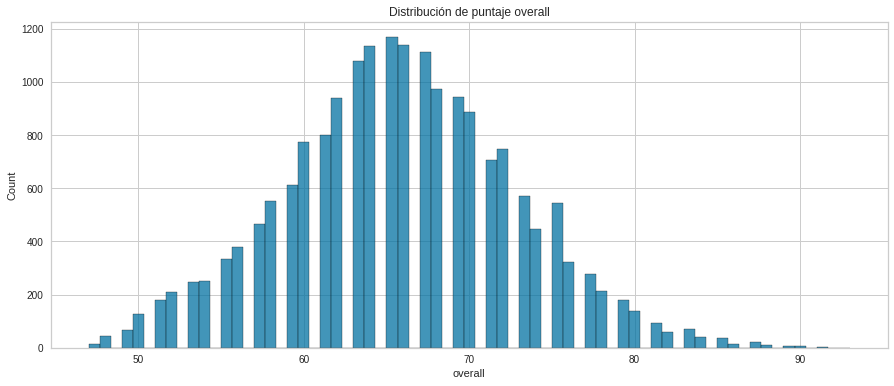

In [6]:
plt.figure(figsize=(15,6))
sns.histplot(df.overall)
plt.title('Distribución de puntaje overall')

Combinando las dos variables anteriores, observamos que independiente de la posición, el mejor jugador de cada una tiene un overall mayor o igual a 79.


In [7]:
df.iloc[df.groupby(df['team_position'])['overall'].idxmax()][['team_position','short_name','overall']]

,team_position,short_name,overall
0,CAM,L. Messi,93
55,CB,M. Hummels,86
17,CDM,Casemiro,89
15,CF,K. Benzema,89
355,CM,I. Fernández,81
2,GK,J. Oblak,91
378,LAM,C. Nkunku,80
33,LB,A. Robertson,87
8,LCB,V. van Dijk,90
24,LCM,T. Kroos,88


Analizando el promedio del overall de los jugadores por club, detectamos que los mejores clubes son todos europeos.

In [8]:
df.groupby("club_name")["overall"].mean().reset_index().sort_values("overall",ascending=False).head(10)

,club_name,overall
216,FC Bayern München,81.045455
489,Real Madrid,79.250000
131,Chelsea,79.212121
214,FC Barcelona,78.909091
374,Liverpool,78.575758
330,Inter,78.000000
387,Manchester United,77.818182
386,Manchester City,77.484848
339,Juventus,77.483871
612,Tottenham Hotspur,77.242424


# Cruces entre variables

A continuación analizamos el cruce entre dos variables agregando la identificación de los mejores jugadores (considerados con un overall mayor a 79 que fue el mínimo obtenido anteriormente). Probamos la combinación de varias variables entre sí, no siendo satisfactorio el hallazgo de grupos diferenciados en todos los casos. Se muestran sólo algunas de aquellas en las que si se evidenciaban grupos diferentes. Distinguiremos a los arqueros y a los mejores jugadores de campo en los gráficos.

Generamos 4 clases, según que el jugador sea(o no) arquero, y según tenga(o no) un overall mayor a 79 .

In [9]:
def f(posicion, overol):
  if overol > 79 and posicion=="GK":
    return "gran_arquero"
  elif overol > 79 and posicion!="GK":
    return "gran_jugador_de_campo"
  elif posicion=="GK":
    return "arquero_normal"
  else:
    return "jugador_normal"

df["clase"] =  df[["team_position", "overall"]].apply(lambda s: f(*s), axis=1)

In [10]:
df[["team_position", "overall", "clase"]]

,team_position,overall,clase
0,CAM,93,gran_jugador_de_campo
1,LS,92,gran_jugador_de_campo
2,GK,91,gran_arquero
3,ST,91,gran_jugador_de_campo
4,LW,91,gran_jugador_de_campo
...,...,...,...
18939,SUB,47,jugador_normal
18940,SUB,47,jugador_normal
18941,RES,47,jugador_normal
18942,RDM,47,jugador_normal


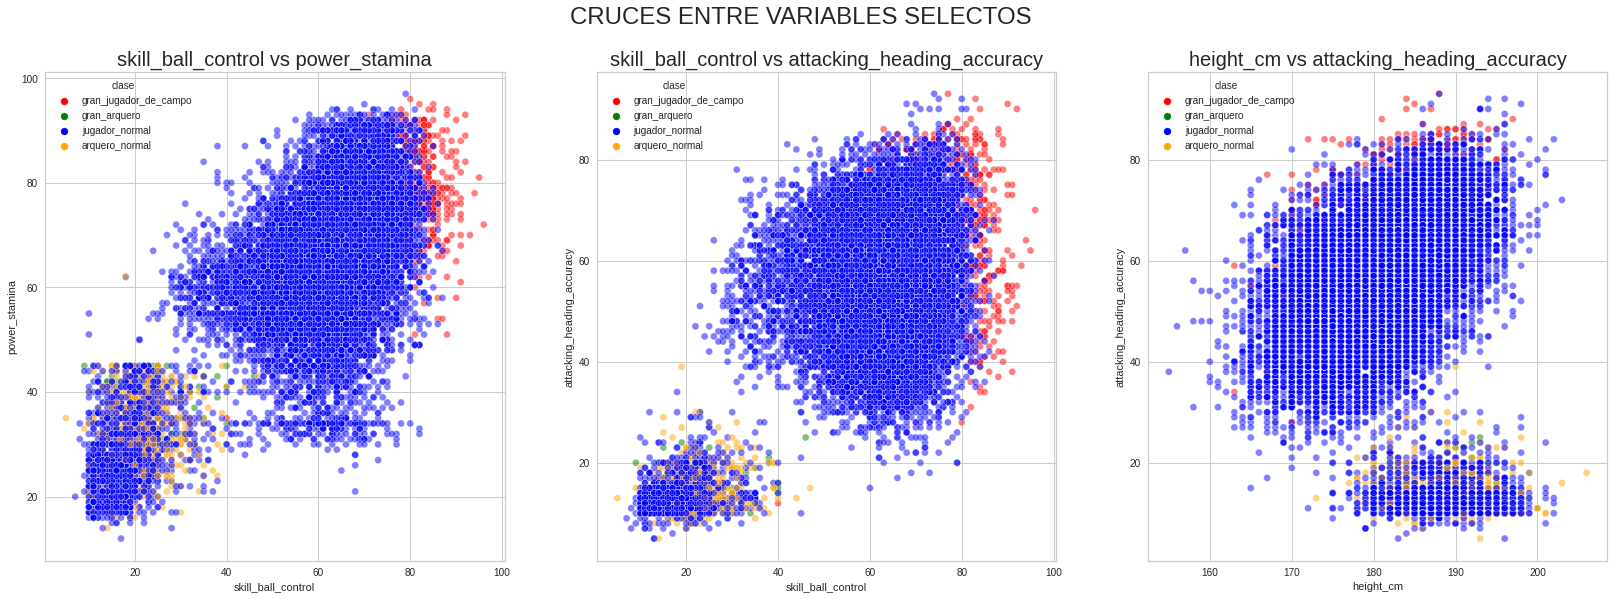

In [55]:
dict_hue_colores={'gran_jugador_de_campo':"red", 'gran_arquero':"green", 'jugador_normal':"blue", 'arquero_normal':"orange"}

def dispersion_bivariable(col1, col2, ax):
  sns.scatterplot(data=df, x=col1, y=col2, hue = "clase", alpha=0.5, palette=dict_hue_colores.values(), ax=ax)#, legend=False)
  ax.set_title(col1+' vs '+col2,size=20)

fig, ax = plt.subplots(1,3,figsize=(28,9))
fig.suptitle("CRUCES ENTRE VARIABLES SELECTOS", fontsize=24)

dispersion_bivariable("skill_ball_control", "power_stamina", ax[0])
dispersion_bivariable('skill_ball_control', 'attacking_heading_accuracy', ax[1])
dispersion_bivariable('height_cm', 'attacking_heading_accuracy', ax[2])

# Clustering

En primer lugar, definimos las variables relacionadas a las habilidades de los jugadores y continuamos el proceso de clustering sólo con aquellos cuyo overall es mayor a 70. Además tuvimos en consideración ignorar aquellas variables que presentaran más de 10000 valores nulos analizados previamente.

In [12]:
col_list = ['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

col_list2 = ['short_name','overall', "team_position"] + col_list 

df_cluster2 = df[df.overall > 70][col_list2].fillna(0)
df_cluster = df_cluster2[col_list]

In [13]:
df_cluster2.head()

,short_name,overall,team_position,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,93,CAM,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,35,24,6,11,15,14,8
1,Cristiano Ronaldo,92,LS,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,32,24,7,11,15,14,11
2,J. Oblak,91,GK,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,12,18,87,92,78,90,90
3,R. Lewandowski,91,ST,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,42,19,15,6,12,8,10
4,Neymar Jr,91,LW,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,30,29,9,9,15,15,11


In [14]:
#Código de escalado comentado luego de ver su impacto negativo en Meanshift.
#scaler = MinMaxScaler()
#df_scaled = scaler.fit_transform(df_cluster)
#
#df_scaled = pd.DataFrame(df_scaled)
#df_scaled.columns = df_cluster.columns 
#
#df_scaled.shape

## K-means

En primer lugar, a través del método del códo analizamos el número ideal de clusters a encontrar variando entre 2 y 11.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

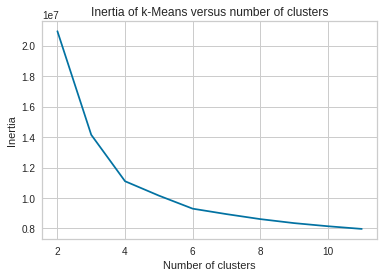

In [15]:
scores = [KMeans(n_clusters=i).fit(df_cluster).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Habiendo identificado el mejor número de clusters (4) procedemos a realizar el proceso de clustering a través de Kmeans.

In [16]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(df_cluster) 

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  11098843.815338241


In [17]:
df_cluster['clusters'] = clusters

Seleccionamos dos habilidades para validar los clusters generados. Vemos que los mismos están separados entre si aunque hay algunos puntos que se mezclan. 





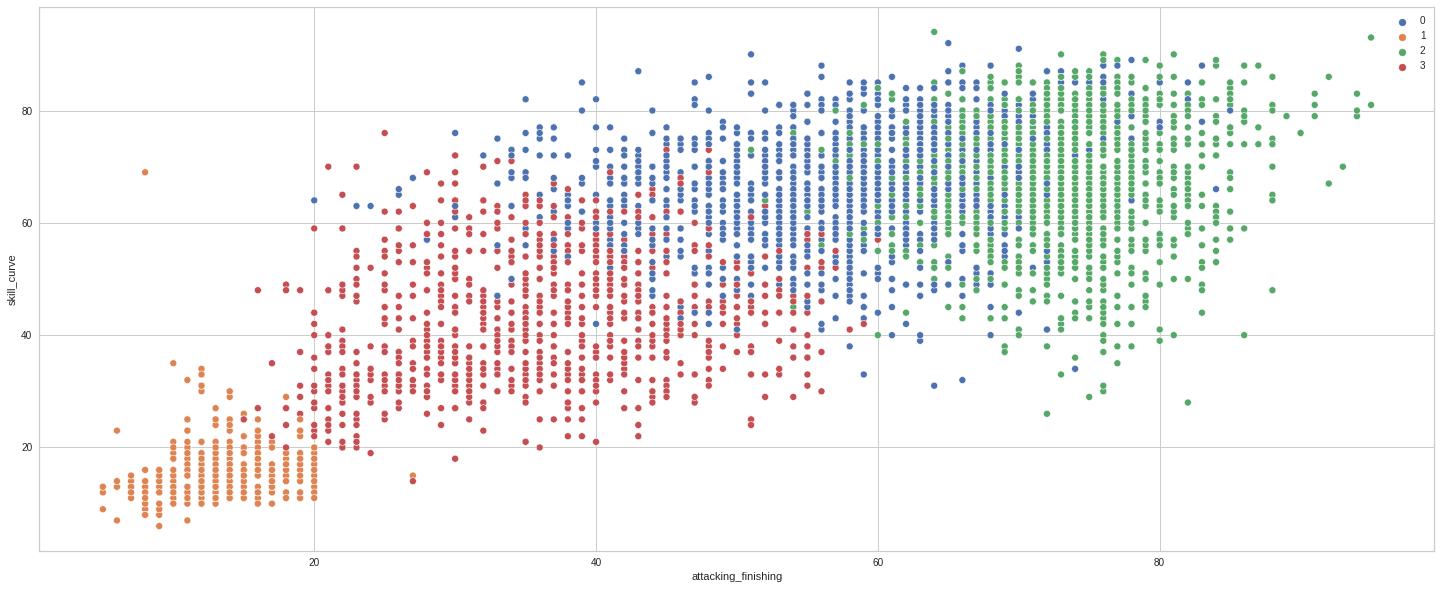

In [18]:
skill_1='attacking_finishing'
skill_2='skill_curve'

plt.figure(figsize=(25,10))
sns.scatterplot(data=df_cluster, x=skill_1, y=skill_2, hue=clusters, alpha=1, palette='deep')

Recuperamos el df previo a Kmeans para evaluar el siguiente método de clustering.

In [19]:
df_cluster = df_cluster.drop(['clusters'], axis=1)

## Mean shift

Durante dicho método, detectamos que si escalamos el dataframe la cantidad de clusters encontrados era mayor a 4000, valor sumamente ilógico dado que representaba un cluster por jugador. Decidimos rechazar el resultado obtenido y eliminar el escalado realizado previamente. A continuación se muestra el resultado sin escalar.

In [20]:
ms = MeanShift(bandwidth=2, bin_seeding=True, n_jobs=-1)
ms.fit(df_cluster)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 3


Resaltamos que la cantidad de clusters hallados no coincide con la cantidad designada a partir del método del codo. 

In [21]:
df_cluster['clusters2'] = clusters2

Al igual que en Kmeans, seleccionamos las mismas habilidades para validar los clusters generados. Vemos que la separación entre los mismos pierde claridad respecto al método anterior. 





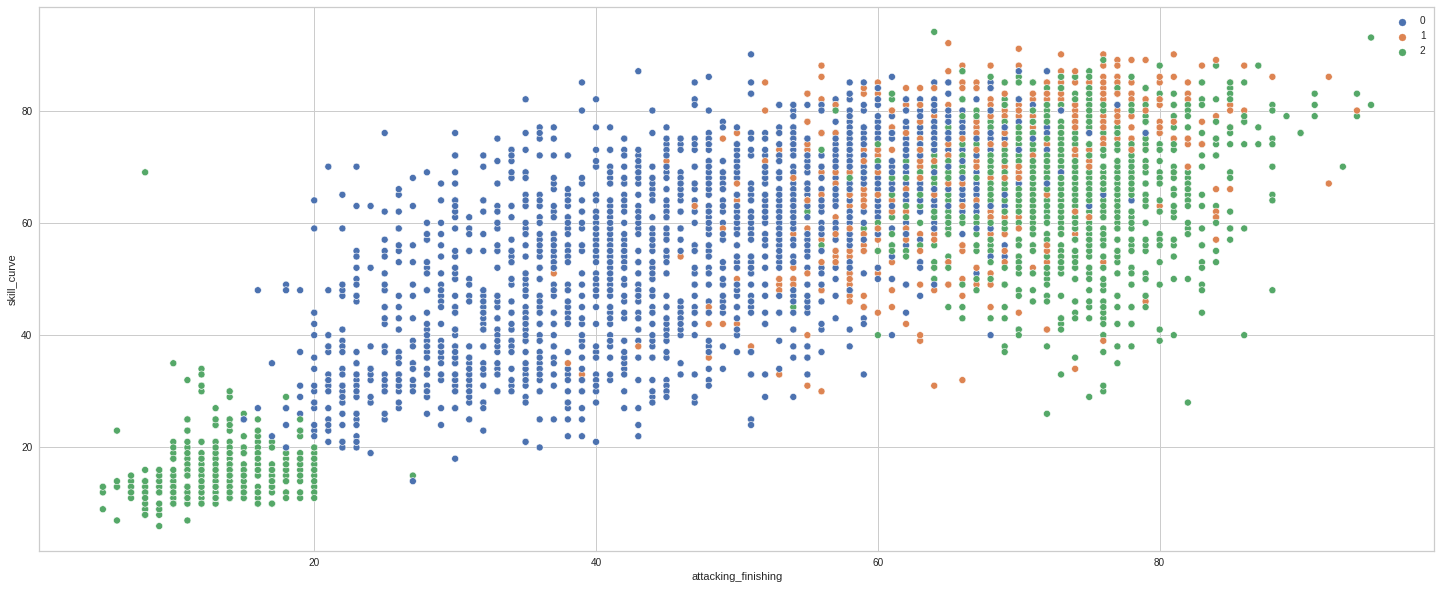

In [22]:
skill_1='attacking_finishing'
skill_2='skill_curve'

plt.figure(figsize=(25,10))
sns.scatterplot(data=df_cluster, x=skill_1, y=skill_2, hue=clusters2, alpha=1, palette='deep')

Volvemos a recuperar el df_cluster

In [23]:
df_cluster = df_cluster.drop(['clusters2'], axis=1)

## Jerarquico

 A continuación probamos la efectividad del clustering jerárquico analizando el hiperparámetro de agrupamiento ("linkage"). Comparamos average y complete pero con el primero los clusters quedaban MUY desbalanceados. 


In [24]:
agl = AgglomerativeClustering(linkage='complete', affinity='cityblock', n_clusters= None, distance_threshold=1000)
agl.fit(df_cluster) 

clusters3 = agl.labels_

labels_unique = np.unique(clusters3)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Jerarquico Agglomerative : %d" % n_clusters_)

Cantidad de clusters encontrados por Jerarquico Agglomerative : 3


Nuevamente, el número de clusters encontrados no coincide con el valor identificado a partir del método del codo.

In [25]:
df_cluster['clusters3'] = clusters3

Seleccionamos las mismas habilidades para validar los clusters generados. Vemos que la separación entre los mismos mejora notablemente.

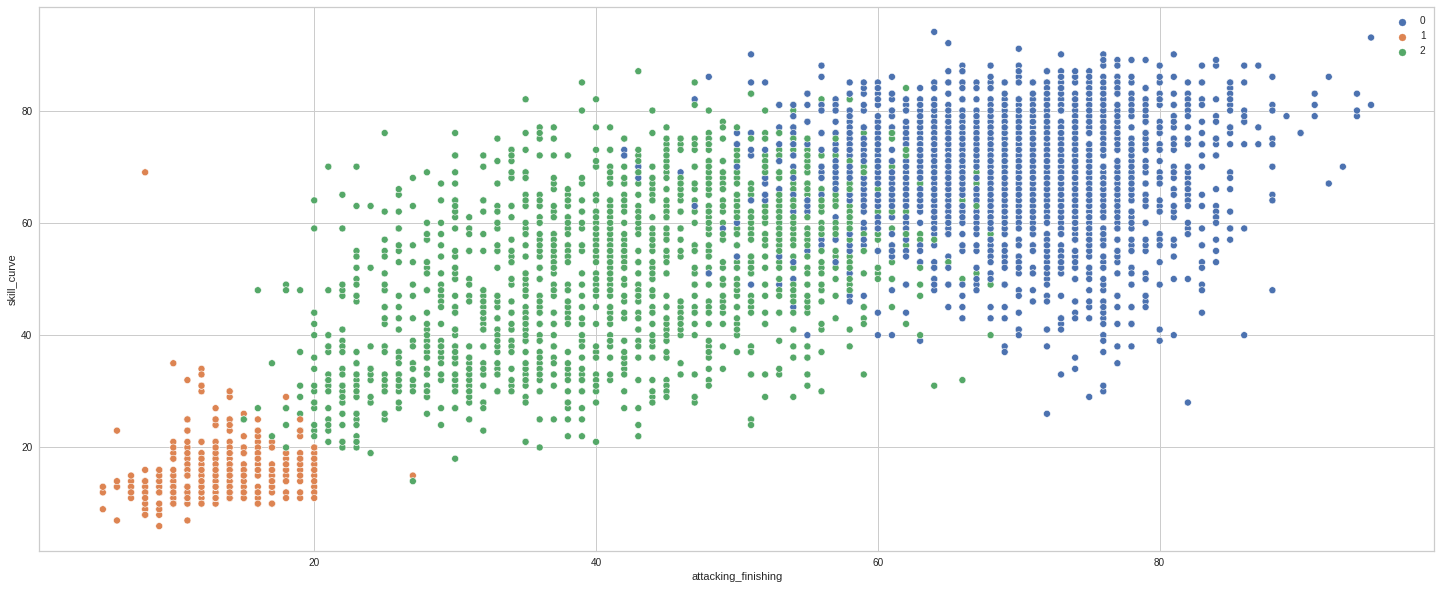

In [26]:
skill_1='attacking_finishing'
skill_2='skill_curve'

plt.figure(figsize=(25,10))
sns.scatterplot(data=df_cluster, x=skill_1, y=skill_2, hue=clusters3, alpha=1, palette='deep')

Recuperamos df_cluster

In [27]:
df_cluster = df_cluster.drop(['clusters3'], axis=1)

# Análisis de clusters

En esta sección, vamos a analizar la calidad de los clusters obtenidos a partir de los diferentes métodos probados anteriormente.

## Kmeans

A través del método de la silueta, analizamos en primer lugar Kmeans con 4 clusters y obtenemos un coeficiente igual a 0.3. Considerando su bajo valor analizamos el comportamiento del coeficiente modificando el número de clusters obteniendo como mejor modelo aquel de 2 clusters. Nos genera confusión que no coincida con el valor identificado a través del método del codo.

In [28]:
print(f'Silhouette Score en Kmeans (n=4): {silhouette_score(df_cluster, clusters)}')

Silhouette Score en Kmeans (n=4): 0.30988045957867183


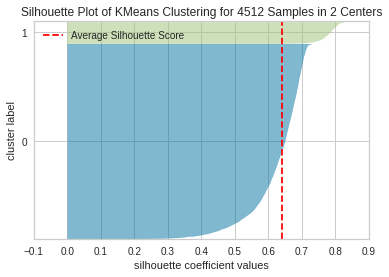

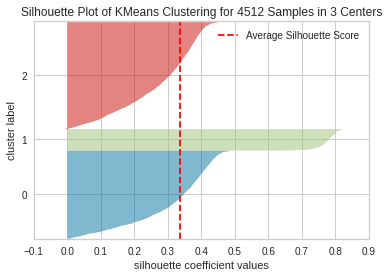

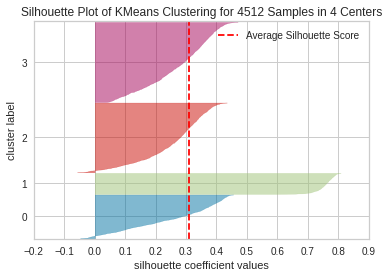

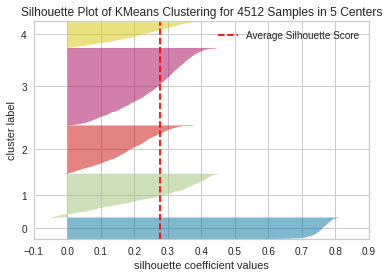

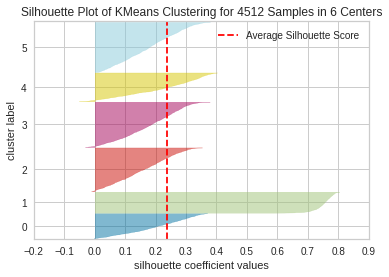

In [29]:
range_n_clusters = [2, 3, 4, 5, 6]

for i in range_n_clusters:

    n_clust = i

    km = KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')

    visualizer.fit(df_cluster)
    visualizer.show()  

## Mean Shift

Confirmamos a través del coeficiente de la silueta del modelo meanshift que su desempeño es pobre siendo el mismo muy cercano a cero. Esto refleja que la distancia entre los 3 clusters encontrados no es significativa.

In [30]:
print(f'Silhouette Score en Mean Shift (n=3): {silhouette_score(df_cluster, clusters2)}')

Silhouette Score en Mean Shift (n=3): 0.04524089402228348


## Jerarquico

A nuestra sorpresa, el coeficiente de la silueta del modelo jerárquico no refleja la claridad de la separación de los clusters observada en el gráfico de validación.

In [31]:
print(f'Silhouette Score en Jerarquico (n=3): {silhouette_score(df_cluster, clusters3)}')

Silhouette Score en Jerarquico (n=3): 0.31223975509328655


In [32]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

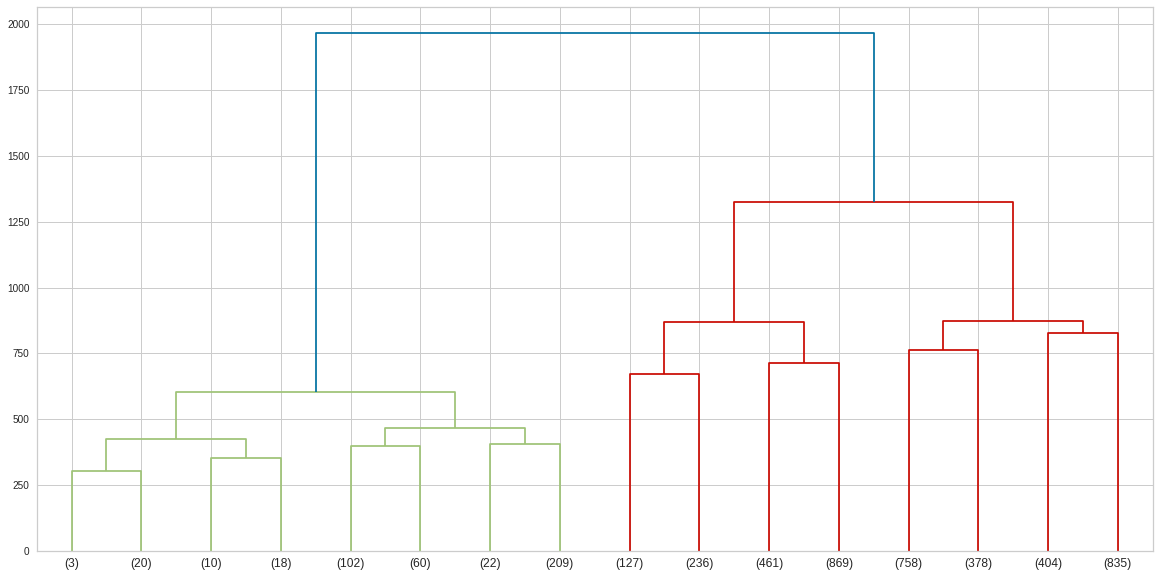

In [33]:
plt.figure(figsize=(20, 10))
plot_dendrogram(agl, truncate_mode='level', p=3)

# Embeddings

https://github.com/DiploDatos/AprendizajeNOSupervisado/blob/master/2021/ntb4_embeddings_fifa2019.ipynb

## T-SNE

In [34]:
print('dimensión del espacio de los datos: ', df_cluster.shape)

dimensión del espacio de los datos:  (4512, 33)


Vamos a agregar una columna booleana que identifique a los arqueros.

In [35]:
df["arquero"]=df.team_position =="GK"

col_list2 = ['short_name','overall', "team_position", "arquero"] + col_list 
df_cluster2 = df[df.overall > 70][col_list2].fillna(0)
df_cluster = df_cluster2[col_list]

In [36]:
df_cluster2.head()

,short_name,overall,team_position,arquero,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,93,CAM,False,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,35,24,6,11,15,14,8
1,Cristiano Ronaldo,92,LS,False,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,32,24,7,11,15,14,11
2,J. Oblak,91,GK,True,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,12,18,87,92,78,90,90
3,R. Lewandowski,91,ST,False,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,42,19,15,6,12,8,10
4,Neymar Jr,91,LW,False,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,30,29,9,9,15,15,11


In [37]:
nof_gks = df_cluster2.arquero.sum()
nof_gks

293

***Hay 293 arqueros en este dataset overall_70***

In [38]:
time_start = time.time()

tsne = manifold.TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000, n_jobs=-1)
X_tsne = tsne.fit_transform(df_cluster)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4512 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computed neighbors for 4512 samples in 0.909s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4512
[t-SNE] Computed conditional probabilities for sample 2000 / 4512
[t-SNE] Computed conditional probabilities for sample 3000 / 4512
[t-SNE] Computed conditional probabilities for sample 4000 / 4512
[t-SNE] Computed conditional probabilities for sample 4512 / 4512
[t-SNE] Mean sigma: 14.289801
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.022522
[t-SNE] KL divergence after 1000 iterations: 1.795762
t-SNE done! Time elapsed: 38.408594369888306 seconds


In [39]:
print("Exhibimos cinco jugadores como resulta en el Embedding:")
X_tsne[:5]

Exhibimos cinco jugadores como resulta en el Embedding:


array([[ 40.706207 ,   7.838227 ],
       [ 45.220215 ,   8.060552 ],
       [-25.914293 ,  42.580475 ],
       [ 46.46253  ,   8.16765  ],
       [ 40.61545  ,   8.0781765]], dtype=float32)

In [40]:
time_start = time.time()

tsne3D = manifold.TSNE(n_components=3, verbose=1,perplexity=30, n_iter=1000, n_jobs=-1)
X_tsne3D = tsne3D.fit_transform(df_cluster)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4512 samples in 0.000s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computed neighbors for 4512 samples in 0.869s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4512
[t-SNE] Computed conditional probabilities for sample 2000 / 4512
[t-SNE] Computed conditional probabilities for sample 3000 / 4512
[t-SNE] Computed conditional probabilities for sample 4000 / 4512
[t-SNE] Computed conditional probabilities for sample 4512 / 4512
[t-SNE] Mean sigma: 14.289801
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.301422
[t-SNE] KL divergence after 1000 iterations: 1.531988
t-SNE done! Time elapsed: 201.1736204624176 seconds


In [41]:
print("Exhibimos cinco jugadores como resulta en el Embedding:")
X_tsne3D[:5]

Exhibimos cinco jugadores como resulta en el Embedding:


array([[ -9.165513 ,  14.018399 ,  12.832226 ],
       [-12.757289 ,  12.871433 ,   9.900783 ],
       [ -5.1717725,  -2.6209948, -18.033005 ],
       [-13.018372 ,  12.118807 ,   9.003338 ],
       [ -8.908151 ,  14.130484 ,  12.689444 ]], dtype=float32)

## ***Agregamos los Embeddings como columnas del df_cluster2, para graficar con comodidad.***

In [42]:
df_cluster2 = pd.concat([df_cluster2, pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"])], axis=1)
df_cluster2 = pd.concat([df_cluster2, pd.DataFrame(X_tsne3D, columns=["tsne3D_x", "tsne3D_y", "tsne3D_z"])], axis=1)

goal_keepers = df_cluster2.loc[df_cluster2.arquero==True]
field_players = df_cluster2.loc[df_cluster2.arquero==False]

great_players = df_cluster2.loc[df_cluster2.overall > 79]

In [43]:
df_cluster2.head()

,short_name,overall,team_position,arquero,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,tsne_x,tsne_y,tsne3D_x,tsne3D_y,tsne3D_z
0,L. Messi,93,CAM,False,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,35,24,6,11,15,14,8,40.706207,7.838227,-9.165513,14.018399,12.832226
1,Cristiano Ronaldo,92,LS,False,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,32,24,7,11,15,14,11,45.220215,8.060552,-12.757289,12.871433,9.900783
2,J. Oblak,91,GK,True,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,12,18,87,92,78,90,90,-25.914293,42.580475,-5.171772,-2.620995,-18.033005
3,R. Lewandowski,91,ST,False,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,42,19,15,6,12,8,10,46.462528,8.167650,-13.018372,12.118807,9.003338
4,Neymar Jr,91,LW,False,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,30,29,9,9,15,15,11,40.615452,8.078176,-8.908151,14.130484,12.689444


In [44]:
traces = []

traces.append(go.Scatter( x = field_players.tsne_x,  
                          y = field_players.tsne_y, 
                          name="jugador de campo", mode='markers', 
                          text = field_players.short_name))

traces.append(go.Scatter( x = goal_keepers.tsne_x, 
                          y = goal_keepers.tsne_y, 
                          name="arquero", mode='markers', 
                          text = goal_keepers.short_name))

traces.append(go.Scatter( x = great_players.tsne_x, 
                          y = great_players.tsne_y, 
                          name="overall > 79", mode='markers', 
                          text = goal_keepers.short_name))


layout = go.Layout( title="Visualización de la base en el espacio tsne-2D",titlefont=dict(size=20),
                    xaxis=dict(title='tsne componente 1'),
                    yaxis=dict(title='tsne componente 2'),
                    autosize=False, width=1000,height=700
                   )

fig = go.Figure(data=traces, layout=layout)
fig.show(renderer="colab")

Los arqueros son parte de una nubecita, los "cracks" están bastante desparramados.

In [45]:
def plot_3d_tsne(subconjunto, etiqueta):
  return go.Scatter3d( x = subconjunto.tsne3D_x,  
                       y = subconjunto.tsne3D_y,
                       z = subconjunto.tsne3D_z,
                       name=etiqueta, mode='markers', 
                       text = subconjunto.short_name)

In [46]:
traces = []
traces.append( plot_3d_tsne(field_players, "jugador de campo"))
traces.append( plot_3d_tsne(great_players, "overall > 79"))
traces.append( plot_3d_tsne(goal_keepers, "arquero"))

layout = go.Layout( title="Visualización de la base en el espacio tsne-3D",titlefont=dict(size=20),
                    xaxis=dict(title='componente 1'),
                    yaxis=dict(title='componente 2'),
                    autosize=False, width=1000,height=700)

fig = go.Figure(data=traces, layout=layout)
fig.show(renderer="colab")

Se ve que todos los arqueros están en una nubecita; enredados con algunos jugadores de campo. Los jugadores "crack" no parecen separarse bien.

## DBScan

Vamos a probar de hacer dbscan, para ver si los arqueros y los puntos enredados con ellos quedan juntos.

In [47]:
from sklearn.cluster import dbscan
from sklearn.cluster import DBSCAN

In [48]:
# Compute DBSCAN
db = DBSCAN(eps=6).fit(X_tsne3D)
labels = db.labels_

no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('No. of clusters: %d' % no_clusters)

No. of clusters: 2


Nos quedamos con eps==6 pues nos dio 2 clusters como resultado, que es lo que quisieramos ver.

In [49]:
labels

array([0, 0, 1, ..., 0, 1, 0])

In [50]:
print("Hay "+str(labels.sum())+" puntos en la nube")

Hay 444 puntos en la nube


In [51]:
df_cluster2["dbscan"] = labels

In [52]:
len(df_cluster2[df_cluster2.arquero==True][df_cluster2.dbscan==1]) == nof_gks

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



True

In [53]:
print("Los "+str(nof_gks)+" arqueros están dentro de la nube de "+str(labels.sum())+" puntos")

Los 293 arqueros están dentro de la nube de 444 puntos


In [54]:
traces = []
traces.append( plot_3d_tsne(df_cluster2.loc[df_cluster2["dbscan"]==0], "normal"))
traces.append( plot_3d_tsne(df_cluster2.loc[df_cluster2["dbscan"]==1], "nube"))
traces.append( plot_3d_tsne(goal_keepers, "arqueros"))

fig = go.Figure(data=traces, layout=layout)
fig.show(renderer="colab")

Como se podía preveer dado que los embeddings son parte del espacio euclideo, con una correcta elección de parámetros, DBSCAN distingue la nube que incluye a los arqueros del resto de los puntos.